In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold, GroupKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression # for classification
from sklearn.svm import LinearSVC, SVC # support vecrors for classifications, there is also SVR for regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
# the reference was helpful in reducing the memory imprint. We need also to choose the fastest and optimize for the efficacy prize.
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

training_data_loaded_=pd.read_csv('train.csv',dtype=dtypes)
training_data_loaded_=training_data_loaded_.drop(["fullscreen","hq","music"],axis=1)
training_data_loaded_.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [ ]:

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

# event_name_dummies=pd.get_dummies(training_data_loaded_['event_name'])
# fqid_dummies=pd.get_dummies(training_data_loaded_['fqid'],dummy_na=True)
# training_data_loaded = pd.concat([training_data_loaded_, event_name_dummies,fqid_dummies], axis=1)
# Events = list(training_data_loaded['event_name'].unique())+list(training_data_loaded['fqid'].unique())
# training_data_loaded['new_elapsed_time_diff'] = np.append(0,np.abs(np.gradient(training_data_loaded['elapsed_time'].values))[:-1])
# multiply_by_time = True
# if multiply_by_time:
#     for c in Events:
#         # print(c)
#         training_data_loaded[c]=training_data_loaded[c] * training_data_loaded['new_elapsed_time_diff']

In [3]:
list(training_data_loaded_['event_name'].unique())

['cutscene_click',
 'person_click',
 'navigate_click',
 'observation_click',
 'notification_click',
 'object_click',
 'object_hover',
 'map_hover',
 'map_click',
 'checkpoint',
 'notebook_click']

In [4]:
list(training_data_loaded_['text'].unique())

['undefined',
 'Whatcha doing over there, Jo?',
 'Just talking to Teddy.',
 'I gotta run to my meeting!',
 'Can I come, Gramps?',
 'Sure thing, Jo. Grab your notebook and come upstairs!',
 'See you later, Teddy.',
 "I get to go to Gramps's meeting!",
 'Now where did I put my notebook?',
 '\\u00f0\\u0178\\u02dc\\u00b4',
 nan,
 'I love these photos of me and Teddy!',
 'Found it!',
 'Gramps is in trouble for losing papers?',
 "This can't be right!",
 'Gramps is a great historian!',
 "Hmm. Button's still not working.",
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
 'Who wants to investigate the shirt artifact?',
 "Not Leopold here. He's been losing papers lately.",
 'Hey!',
 "It's true, they do keep going missing lately.",
 'See?',
 'Besides, I already figured out the shirt.',
 "It's a women's basketball jersey!",
 'That settles it.',
 'Wells, finish up your report.',
 "Leopold, why don't you help me set up in the Capitol?",
 'We need to talk about that missing paper

(array([2.002203e+06, 9.000000e+00, 1.700000e+01, 8.000000e+00,
        1.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        1.000000e+00, 3.000000e+00]),
 array([0.00000000e+00, 2.45163700e+07, 4.90327400e+07, 7.35491120e+07,
        9.80654800e+07, 1.22581848e+08, 1.47098224e+08, 1.71614592e+08,
        1.96130960e+08, 2.20647328e+08, 2.45163696e+08]),
 <BarContainer object of 10 artists>)

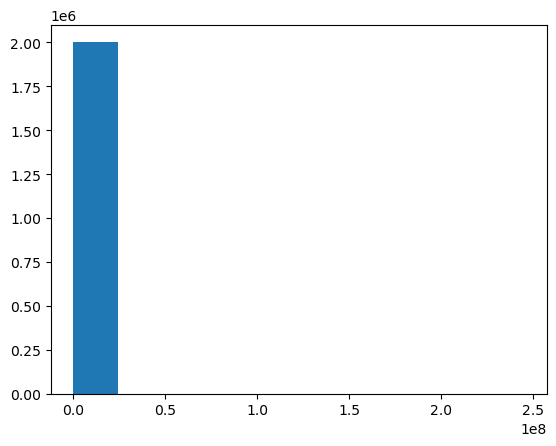

In [5]:
plt.figure(0)
plt.hist(training_data_loaded_['hover_duration'].values)
# plt.xlim(right=1000000)

In [10]:

def feature_engineering(data_df):
    extend = True
    if extend:
        event_name_dummies=pd.get_dummies(data_df['event_name'])
        data_df = pd.concat([data_df,event_name_dummies], axis=1)
        Events = ['navigate_click','observation_click','object_click','map_hover','notebook_click']
        #     Events = list(data_df['event_name'].unique())

    time_scaler= 10000
    data_df['new_elapsed_time_diff'] = np.append(0,np.abs(np.gradient(data_df['elapsed_time'].values))[:-1]/time_scaler)
    # data_df['new_elapsed_time_diff']=data_df['new_elapsed_time_diff']/10000
    data_df['hover_duration']=data_df['hover_duration']/10000
    
    Categories_prime = ['text','text_fqid']
    Categories_secondary = ['name','event_name','fqid','room_fqid']#,'music',"fullscreen","hq"]
    Numeric_prime = ['hover_duration','new_elapsed_time_diff'] #'elapsed_time','new_elapsed_time_diff',
    Numeric_secondary = ['room_coor_x','room_coor_y','screen_coor_x','screen_coor_y','page'] # 'level',

    Include_secondary_cat =True
    Include_secondary_num =True

    df_object_list = [] # will contain a list of data frame objects each is afeature dimension
    for i in Categories_prime:
        summary = data_df.groupby(['session_id','level_group'])[i].agg('nunique')
        summary.name =summary.name+'_unique'
        df_object_list.append(summary)
        summary = data_df.groupby(['session_id','level_group'])[i].agg('size')
        summary.name =summary.name+'_size'
        df_object_list.append(summary)
    for i in Numeric_prime:
        summary = data_df.groupby(['session_id','level_group'])[i].agg('mean')
        summary.name =summary.name+'_mean'
        df_object_list.append(summary)
        summary = data_df.groupby(['session_id','level_group'])[i].agg('std')
        summary.name =summary.name+'_std'
        df_object_list.append(summary)
        summary = data_df.groupby(['session_id','level_group'])[i].agg('sum')
        summary.name =summary.name+'_sum'
        df_object_list.append(summary)
        summary = data_df.groupby(['session_id','level_group'])[i].agg('max')
        summary.name =summary.name+'_max'
        df_object_list.append(summary)
        # summary = data_df.groupby(['session_id','level_group'])[i].agg('median')
        # summary.name =summary.name+'_med'
        # df_object_list.append(summary)
        # summary = data_df.groupby(['session_id','level_group'])[i].agg('min')
        # summary.name =summary.name+'_min'
        # df_object_list.append(summary)
    if extend:
        for i in Events:
            summary = data_df.groupby(['session_id','level_group'])[i].agg('sum')
            summary.name =str(summary.name)+'_sum'
            df_object_list.append(summary)
    
    if Include_secondary_cat: 
        for i in Categories_secondary:
            summary = data_df.groupby(['session_id','level_group'])[i].agg('nunique')
            summary.name =summary.name+'_unique'
            df_object_list.append(summary)
            summary = data_df.groupby(['session_id','level_group'])[i].agg('size')
            summary.name =summary.name+'_size'
            df_object_list.append(summary)
    if Include_secondary_num: 
        for i in Numeric_secondary:
            summary = data_df.groupby(['session_id','level_group'])[i].agg('mean')
            summary.name =summary.name+'_mean'
            df_object_list.append(summary)
            summary = data_df.groupby(['session_id','level_group'])[i].agg('max')
            summary.name =summary.name+'_max'
            df_object_list.append(summary)
            # summary = data_df.groupby(['session_id','level_group'])[i].agg('median')
            # summary.name =summary.name+'_med'
            # df_object_list.append(summary)
            summary = data_df.groupby(['session_id','level_group'])[i].agg('std')
            summary.name =summary.name+'_std'
            df_object_list.append(summary)
            # summary = data_df.groupby(['session_id','level_group'])[i].agg('sum')
            # summary.name =summary.name+'_sum'
            # df_object_list.append(summary)
            # summary = data_df.groupby(['session_id','level_group'])[i].agg('min')
            # summary.name =summary.name+'_min'
            # df_object_list.append(summary)
#     summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('mean')
#     summary.name =summary.name+'_map_hover_mean'
#     df_object_list.append(summary)
# #     summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('max')
# #     summary.name =summary.name+'_map_hover_max'
# #     df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('median')
#     # summary.name =summary.name+'_map_hover_med'
#     # df_object_list.append(summary)
#     summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('std')
#     summary.name =summary.name+'_map_hover_std'
#     df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('sum')
#     # summary.name =summary.name+'_map_hover_sum'
#     # df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='map_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('min')
#     # summary.name =summary.name+'_map_hover_min'
#     # df_object_list.append(summary)
#     summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('mean')
#     summary.name =summary.name+'_obj_hover_mean'
#     df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('max')
#     # summary.name =summary.name+'_obj_hover_max'
#     # df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('median')
#     # summary.name =summary.name+'_obj_hover_med'
#     # df_object_list.append(summary)
#     summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('std')
#     summary.name =summary.name+'_obj_hover_std'
#     df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('sum')
#     # summary.name =summary.name+'_obj_hover_sum'
#     # df_object_list.append(summary)
#     # summary = data_df.loc[data_df['event_name']=='object_hover'].groupby(['session_id','level_group'])['hover_duration'].agg('min')
#     # summary.name =summary.name+'_obj_hover_min'
#     # df_object_list.append(summary)
    df = pd.concat(df_object_list,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

training_data = feature_engineering(training_data_loaded_)

In [11]:
# reading and formatting the labels
training_labels = pd.read_csv("train_labels.csv")
training_labels=training_labels.rename(columns={"session_id":"session_id_q"})
training_labels[["session_id","question"]] = training_labels["session_id_q"].str.split("_q",expand=True)
training_labels= training_labels.drop("session_id_q",axis=1)
training_labels = training_labels.astype({"session_id":"int64","correct":"int8"})
# training_labels.head(10) # labels

In [12]:
training_labels['correct'].values.mean()

0.7056347791641909

In [13]:
# splitting the answer to every question (labels), likely we will need to classify each alone
q1 = training_labels[training_labels['question']=='1'].rename(columns={"correct":"q1"}).drop("question",axis=1) # simply the session ID and the asscociated question label
q2 = training_labels[training_labels['question']=='2'].rename(columns={"correct":"q2"}).drop("question",axis=1)
q3 = training_labels[training_labels['question']=='3'].rename(columns={"correct":"q3"}).drop("question",axis=1)
q4 = training_labels[training_labels['question']=='4'].rename(columns={"correct":"q4"}).drop("question",axis=1)
q5 = training_labels[training_labels['question']=='5'].rename(columns={"correct":"q5"}).drop("question",axis=1)
q6 = training_labels[training_labels['question']=='6'].rename(columns={"correct":"q6"}).drop("question",axis=1)
q7 = training_labels[training_labels['question']=='7'].rename(columns={"correct":"q7"}).drop("question",axis=1)
q8 = training_labels[training_labels['question']=='8'].rename(columns={"correct":"q8"}).drop("question",axis=1)
q9 = training_labels[training_labels['question']=='9'].rename(columns={"correct":"q9"}).drop("question",axis=1)
q10 = training_labels[training_labels['question']=='10'].rename(columns={"correct":"q10"}).drop("question",axis=1)
q11 = training_labels[training_labels['question']=='11'].rename(columns={"correct":"q11"}).drop("question",axis=1)
q12 = training_labels[training_labels['question']=='12'].rename(columns={"correct":"q12"}).drop("question",axis=1)
q13 = training_labels[training_labels['question']=='13'].rename(columns={"correct":"q13"}).drop("question",axis=1)
q14 = training_labels[training_labels['question']=='14'].rename(columns={"correct":"q14"}).drop("question",axis=1)
q15 = training_labels[training_labels['question']=='15'].rename(columns={"correct":"q15"}).drop("question",axis=1)
q16 = training_labels[training_labels['question']=='16'].rename(columns={"correct":"q16"}).drop("question",axis=1)
q17 = training_labels[training_labels['question']=='17'].rename(columns={"correct":"q17"}).drop("question",axis=1)
q18 = training_labels[training_labels['question']=='18'].rename(columns={"correct":"q18"}).drop("question",axis=1)
# print(q18.shape)
# q18.head()

In [14]:
# this entire step is unnecessary perhaps, nut I felt like we need to make sure labels and features align in order, also it doesn't take time
training_data_0_4_w_labels = training_data.loc[training_data['level_group']=='0-4'].drop('level_group',axis=1) # separating the time series stages
training_data_0_4_w_labels = pd.merge(training_data_0_4_w_labels,q1,on="session_id") # this is unnecessary but just to make sure labes are ordered correctly 
training_data_0_4_w_labels = pd.merge(training_data_0_4_w_labels,q2,on="session_id")
training_data_0_4_w_labels = pd.merge(training_data_0_4_w_labels,q3,on="session_id")
training_data_0_4_w_labels = pd.merge(training_data_0_4_w_labels,q4,on="session_id")
training_data_5_12_w_labels = training_data.loc[training_data['level_group']=='5-12'].drop('level_group',axis=1)
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q5,on="session_id") # this is unnecessary but just to make sure labes are ordered correctly 
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q6,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q7,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q8,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q9,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q10,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q11,on="session_id")
training_data_5_12_w_labels = pd.merge(training_data_5_12_w_labels,q12,on="session_id")
training_data_13_22_w_labels = training_data.loc[training_data['level_group']=='13-22'].drop('level_group',axis=1)
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q13,on="session_id") # this is unnecessary but just to make sure labes are ordered correctly 
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q14,on="session_id")
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q15,on="session_id")
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q16,on="session_id")
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q17,on="session_id")
training_data_13_22_w_labels = pd.merge(training_data_13_22_w_labels,q18,on="session_id")
# training_data_13_22_w_labels.head()

In [15]:
training_data.columns

Index(['level_group', 'text_unique', 'text_size', 'text_fqid_unique',
       'text_fqid_size', 'hover_duration_mean', 'hover_duration_std',
       'hover_duration_sum', 'hover_duration_max',
       'new_elapsed_time_diff_mean', 'new_elapsed_time_diff_std',
       'new_elapsed_time_diff_sum', 'new_elapsed_time_diff_max',
       'navigate_click_sum', 'observation_click_sum', 'object_click_sum',
       'map_hover_sum', 'notebook_click_sum', 'name_unique', 'name_size',
       'event_name_unique', 'event_name_size', 'fqid_unique', 'fqid_size',
       'room_fqid_unique', 'room_fqid_size', 'room_coor_x_mean',
       'room_coor_x_max', 'room_coor_x_std', 'room_coor_y_mean',
       'room_coor_y_max', 'room_coor_y_std', 'screen_coor_x_mean',
       'screen_coor_x_max', 'screen_coor_x_std', 'screen_coor_y_mean',
       'screen_coor_y_max', 'screen_coor_y_std', 'page_mean', 'page_max',
       'page_std'],
      dtype='object')

5.721407930844345
5.625637092418827


Text(0, 0.5, '% F1 hist')

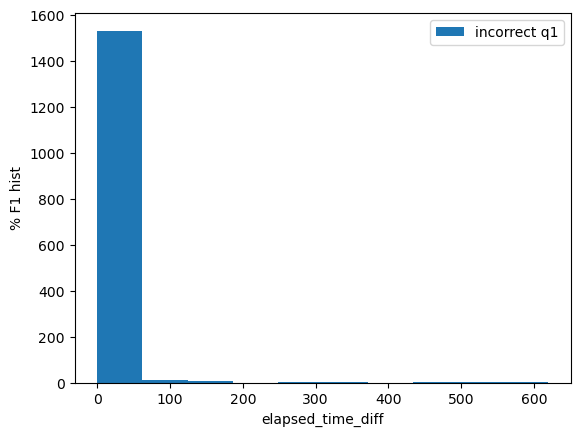

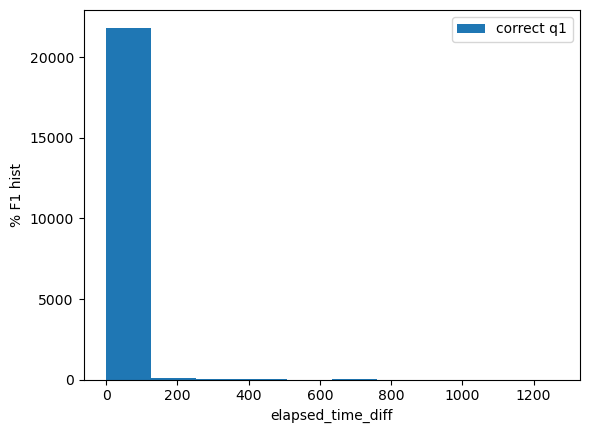

In [16]:
qn = 'q3'
feature ='new_elapsed_time_diff_mean'
print(training_data_0_4_w_labels.loc[training_data_0_4_w_labels[qn]==0,feature].values.mean())
print(training_data_0_4_w_labels.loc[training_data_0_4_w_labels[qn]==1,feature].values.mean())
plt.figure(0)
plt.hist(training_data_0_4_w_labels.loc[training_data_0_4_w_labels[qn]==0,feature].values,label='incorrect q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")
# plt.xlim(right=80)
# plt.xticks(np.arange(0, 2000))
plt.figure(1)
plt.hist(training_data_0_4_w_labels.loc[training_data_0_4_w_labels[qn]==1,feature].values,label='correct q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")
# plt.xlim(right=80)
# plt.xticks(np.arange(0, 2000))

0.5358766279549227
0.5805216732977894


Text(0, 0.5, '% F1 hist')

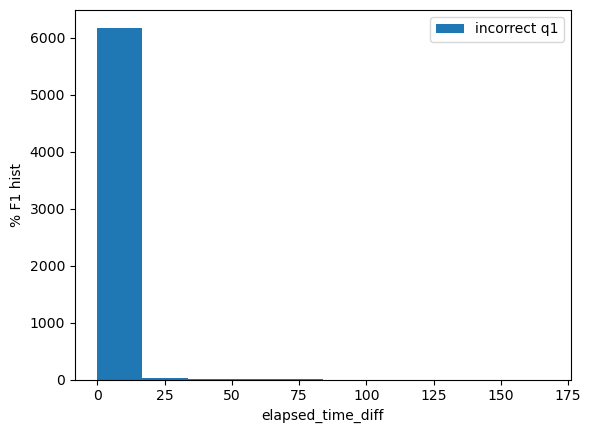

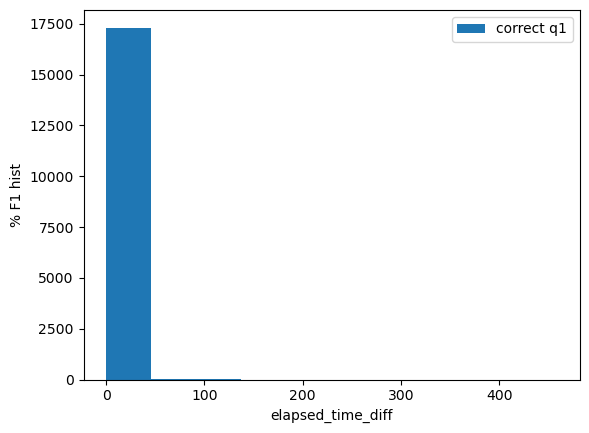

In [17]:

qn = 'q7'
print(training_data_5_12_w_labels.loc[training_data_5_12_w_labels[qn]==0,feature].values.mean())
print(training_data_5_12_w_labels.loc[training_data_5_12_w_labels[qn]==1,feature].values.mean())
plt.figure(0)
plt.hist(training_data_5_12_w_labels.loc[training_data_5_12_w_labels[qn]==0,feature].values,label='incorrect q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")
# plt.xlim(right=8)
# plt.xticks(np.arange(0, 2000))
plt.figure(1)
plt.hist(training_data_5_12_w_labels.loc[training_data_5_12_w_labels[qn]==1,feature].values,label='correct q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")

1.3545905784921137
0.4134081460199003


Text(0, 0.5, '% F1 hist')

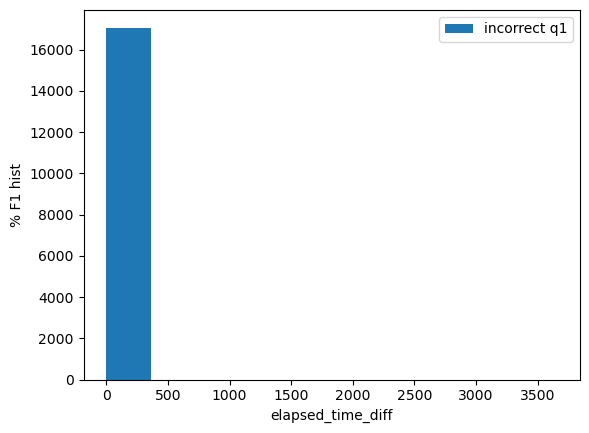

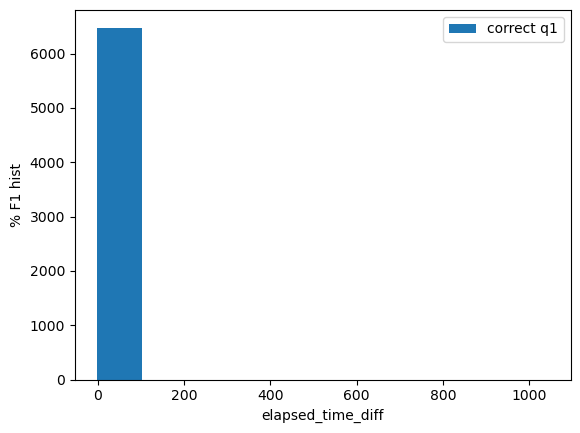

In [289]:
qn = 'q13'
print(training_data_13_22_w_labels.loc[training_data_13_22_w_labels[qn]==0,feature].values.mean())
print(training_data_13_22_w_labels.loc[training_data_13_22_w_labels[qn]==1,feature].values.mean())
plt.figure(0)
plt.hist(training_data_13_22_w_labels.loc[training_data_13_22_w_labels[qn]==0,feature].values,label='incorrect q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")
# plt.xlim(right=8)
# plt.xticks(np.arange(0, 2000))
plt.figure(1)
plt.hist(training_data_13_22_w_labels.loc[training_data_13_22_w_labels[qn]==1,feature].values,label='correct q1')
plt.legend(loc='best')
plt.xlabel("elapsed_time_diff")
plt.ylabel("% F1 hist")

(array([  167.,     0.,     0.,  1165.,     0.,     0.,  3157.,     0.,
            0., 12591.]),
 array([ 8. ,  8.3,  8.6,  8.9,  9.2,  9.5,  9.8, 10.1, 10.4, 10.7, 11. ]),
 <BarContainer object of 10 artists>)

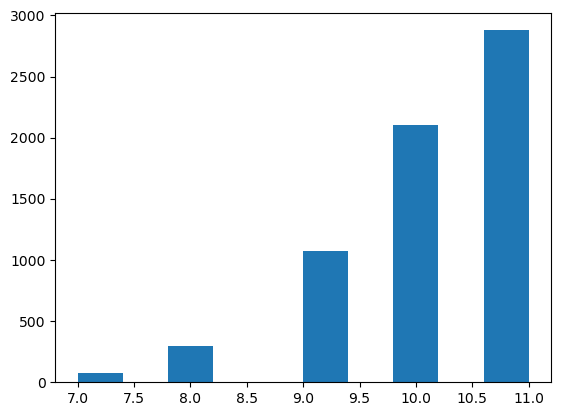

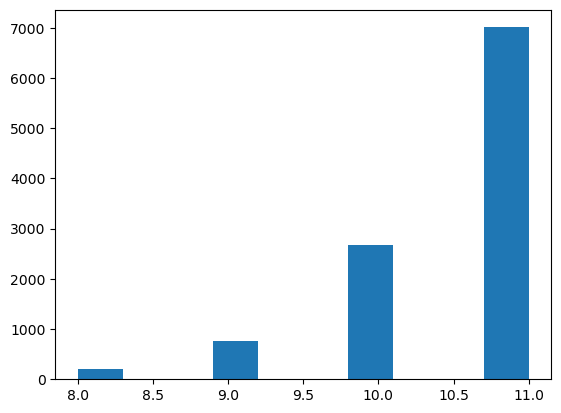

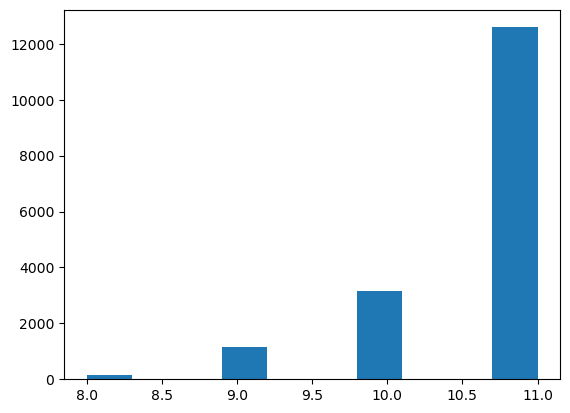

In [330]:
plt.figure(0)
plt.hist(training_data_0_4_w_labels.loc[training_data_0_4_w_labels['q1']==0,'event_name_unique'].values)
plt.figure(1)
plt.hist(training_data_5_12_w_labels.loc[training_data_5_12_w_labels['q5']==0,'event_name_unique'].values)
plt.figure(2)
plt.hist(training_data_13_22_w_labels.loc[training_data_13_22_w_labels['q13']==0,'event_name_unique'].values)

(array([  249.,     0.,     0.,  1624.,     0.,     0.,  4602.,     0.,
            0., 17087.]),
 array([ 8. ,  8.3,  8.6,  8.9,  9.2,  9.5,  9.8, 10.1, 10.4, 10.7, 11. ]),
 <BarContainer object of 10 artists>)

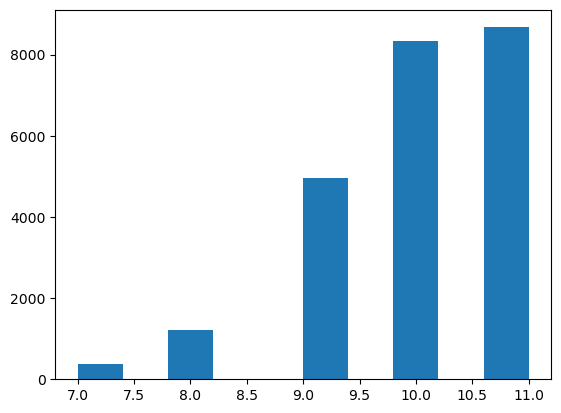

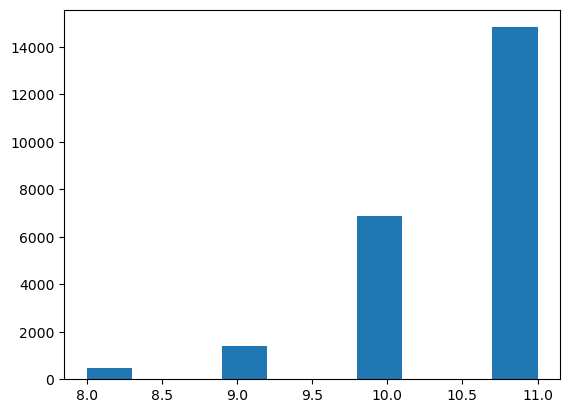

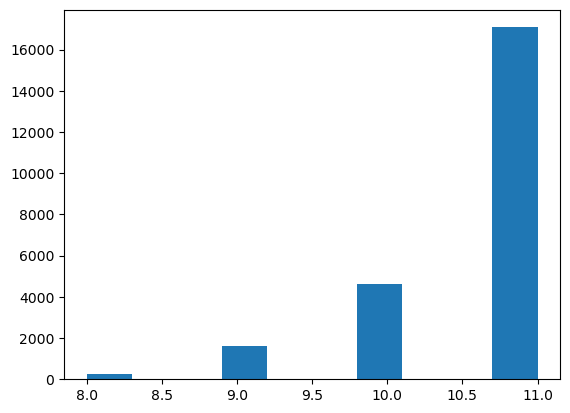

In [75]:
plt.figure(0)
plt.hist(training_data_0_4_w_labels['event_name_unique'].values)
plt.figure(1)
plt.hist(training_data_5_12_w_labels['event_name_unique'].values)
plt.figure(2)
plt.hist(training_data_13_22_w_labels['event_name_unique'].values)

In [8]:
# separating ans splitting the data
y1= training_data_0_4_w_labels['q1'].values
y2= training_data_0_4_w_labels['q2'].values
y3= training_data_0_4_w_labels['q3'].values
y4= training_data_0_4_w_labels['q4'].values
X_1_to_4 = training_data_0_4_w_labels.drop(["session_id","q1","q2","q3","q4"],axis=1).values
y5= training_data_5_12_w_labels['q5'].values
y6= training_data_5_12_w_labels['q6'].values
y7= training_data_5_12_w_labels['q7'].values
y8= training_data_5_12_w_labels['q8'].values
y9= training_data_5_12_w_labels['q9'].values
y10= training_data_5_12_w_labels['q10'].values
y11= training_data_5_12_w_labels['q11'].values
y12= training_data_5_12_w_labels['q12'].values
X_5_to_12 = training_data_5_12_w_labels.drop(["session_id","q5","q6","q7","q8","q9","q10","q11","q12"],axis=1).values
y13= training_data_13_22_w_labels['q13'].values
y14= training_data_13_22_w_labels['q14'].values
y15= training_data_13_22_w_labels['q14'].values
y16= training_data_13_22_w_labels['q15'].values
y17= training_data_13_22_w_labels['q16'].values
y18= training_data_13_22_w_labels['q17'].values
X_13_to_18 = training_data_13_22_w_labels.drop(["session_id","q13","q14","q15","q16","q17","q18"],axis=1).values


In [9]:
X_1_to_4_train, X_1_to_4_val, y1_train, y1_val,y2_train, y2_val,y3_train, y3_val,y4_train, y4_val = train_test_split(X_1_to_4,y1,y2,y3,y4,train_size=0.8)
X_5_to_12_train, X_5_to_12_val, y5_train, y5_val,y6_train, y6_val,y7_train, y7_val,y8_train, y8_val,y9_train, y9_val,y10_train, y10_val,y11_train, y11_val,y12_train, y12_val = train_test_split(X_5_to_12,y5,y6,y7,y8,y9,y10,y11,y12,train_size=0.8)
X_13_to_18_train, X_13_to_18_val,y13_train, y13_val,y14_train, y14_val,y15_train, y15_val,y16_train, y16_val,y17_train, y17_val,y18_train, y18_val = train_test_split(X_1_to_4,y13,y14,y15,y16,y17,y18,train_size=0.8)

In [ ]:
# # SSM with rbf could be the most robust but not sure if it is worth it
# class Question_classifier(Pipeline):
#     def __init__(self) -> None:
#         #super().__init__()
#         # self.Pipe = Pipeline([('scaler',StandardScaler()),
#         #                       ('model',SVC(C=10,kernel='rbf'))])
#         self.Pipe = Pipeline([('model',SVC(C=1,kernel='rbf'))])
#     def fit(self,X,Y):
#         self.Pipe.fit(X,Y)
#     def predict(self,X):
#         return self.Pipe.predict(X)
#     def score(self,X,Y):
#         return self.Pipe.score(X,Y)
    
# X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
#           X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
#           X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
# Y_train = [y1_train,y2_train,y3_train,y4_train,
#            y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
#            y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

# X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
#          X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
#          X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

# Y_val = [y1_val,y2_val,y3_val,y4_val,
#           y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
#           y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

# Q=[]
# train_score =[]
# val_score =[]
# for i in range(18):
#     Q.append(Question_classifier())
#     Q[i].fit(X_train[i],Y_train[i])
#     train_score.append(Q[i].score(X_train[i],Y_train[i]))
#     val_score.append(Q[i].score(X_val[i],Y_val[i]))

# print("training average score using SVM with 0.1 reg and rbf", np.array(train_score).mean())
# print(train_score)
# print("validation average score using SVM with 0.1 reg and rbf", np.array(val_score).mean())
# print(val_score)
# ###Q[0].Pipe.steps[1][1].kernel   

In [ ]:
# a simpler linear large margin classifier with just some regularization, could help us win the efficacy prize
class Question_classifier(Pipeline):
    def __init__(self) -> None:
        #super().__init__()
        self.Pipe = Pipeline([('scaler',StandardScaler()),
                              ('model',SGDClassifier(loss='hinge',alpha=0.1))])
        # self.Pipe = Pipeline([('model',SGDClassifier(loss='hinge',alpha=1))])
    def fit(self,X,Y):
        self.Pipe.fit(X,Y)
    def predict(self,X):
        return self.Pipe.predict(X)
    def score(self,X,Y):
        return self.Pipe.score(X,Y)
    
X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
          X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
          X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
Y_train = [y1_train,y2_train,y3_train,y4_train,
           y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
           y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
         X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
         X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

Y_val = [y1_val,y2_val,y3_val,y4_val,
          y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
          y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

Q=[]
train_score =[]
val_score =[]
for i in range(18):
    Q.append(Question_classifier())
    Q[i].fit(X_train[i],Y_train[i])
    train_score.append(Q[i].score(X_train[i],Y_train[i]))
    val_score.append(Q[i].score(X_val[i],Y_val[i]))

print("training average score using Linear Pegasos with 0.1 reg", np.array(train_score).mean())
print(train_score)
print("validation average score using Linear Pegasos with 0.1 reg", np.array(val_score).mean())
print(val_score)
if (True):
    temp=np.array(Q[0].Pipe.steps[1][1].coef_)
    imp=np.zeros(temp.shape)
    for i in range(18):
        temp=np.array(Q[i].Pipe.steps[1][1].coef_)
        temp = np.abs(temp/np.max(np.abs(temp)))
        imp = imp+temp
        #print(f"for Q{i}, per feature imprtance is {temp}")
    imp = 100*imp/np.sum(imp)
    print(f" overal feature imprtances as % are {imp}")
    imp=imp[0,:]
    plt.figure(0,figsize=(40,10))
    plt.bar(np.arange(len(imp)),imp,label=f"Overall validation score is {np.array(val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("The feature number")
    plt.ylabel("% contribution in the importance of Pegasos")
    plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    plt.figure(1)
    plt.bar(np.arange(1,len(val_score)+1),val_score,label=f"validation score is{np.array(val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("question number")
    plt.ylabel("% validation score per qustion")
    

In [318]:
qn=1
sum(Y_train[qn]==0)/len(Y_train[qn])

0.020743806037455566

training average score using Logistic regression with 0.1 reg 0.7367823816176514
[0.7360072152368826, 0.9792031407501725, 0.9345323359329407, 0.7978672608626453, 0.6315984932887686, 0.7882115762109396, 0.7390843015544591, 0.6271420234495199, 0.7486338797814208, 0.6075123348718765, 0.656427396678869, 0.8631757652925884, 0.726882062708897, 0.7097458751127381, 0.7097458751127381, 0.5819937397209402, 0.7354766831131625, 0.6888429094381665]
validation average score using Logistic regression with 0.1 reg 0.7335738029563619
[0.7301082113303629, 0.9770846594525779, 0.9304052620411627, 0.803946530872056, 0.6312327604498197, 0.7710587736049226, 0.7455972841077869, 0.6189263738595374, 0.7407171652875026, 0.6159558667515384, 0.6569064290260981, 0.8616592403988966, 0.7222575854020794, 0.7042223636749416, 0.7042223636749416, 0.5745809463186929, 0.7328665393592192, 0.6825800976023764]
 overal feature imprtances as % are [[0.43917637 0.46296462 0.48819618 3.10702371 6.27897543 3.22786119
  5.47944615 

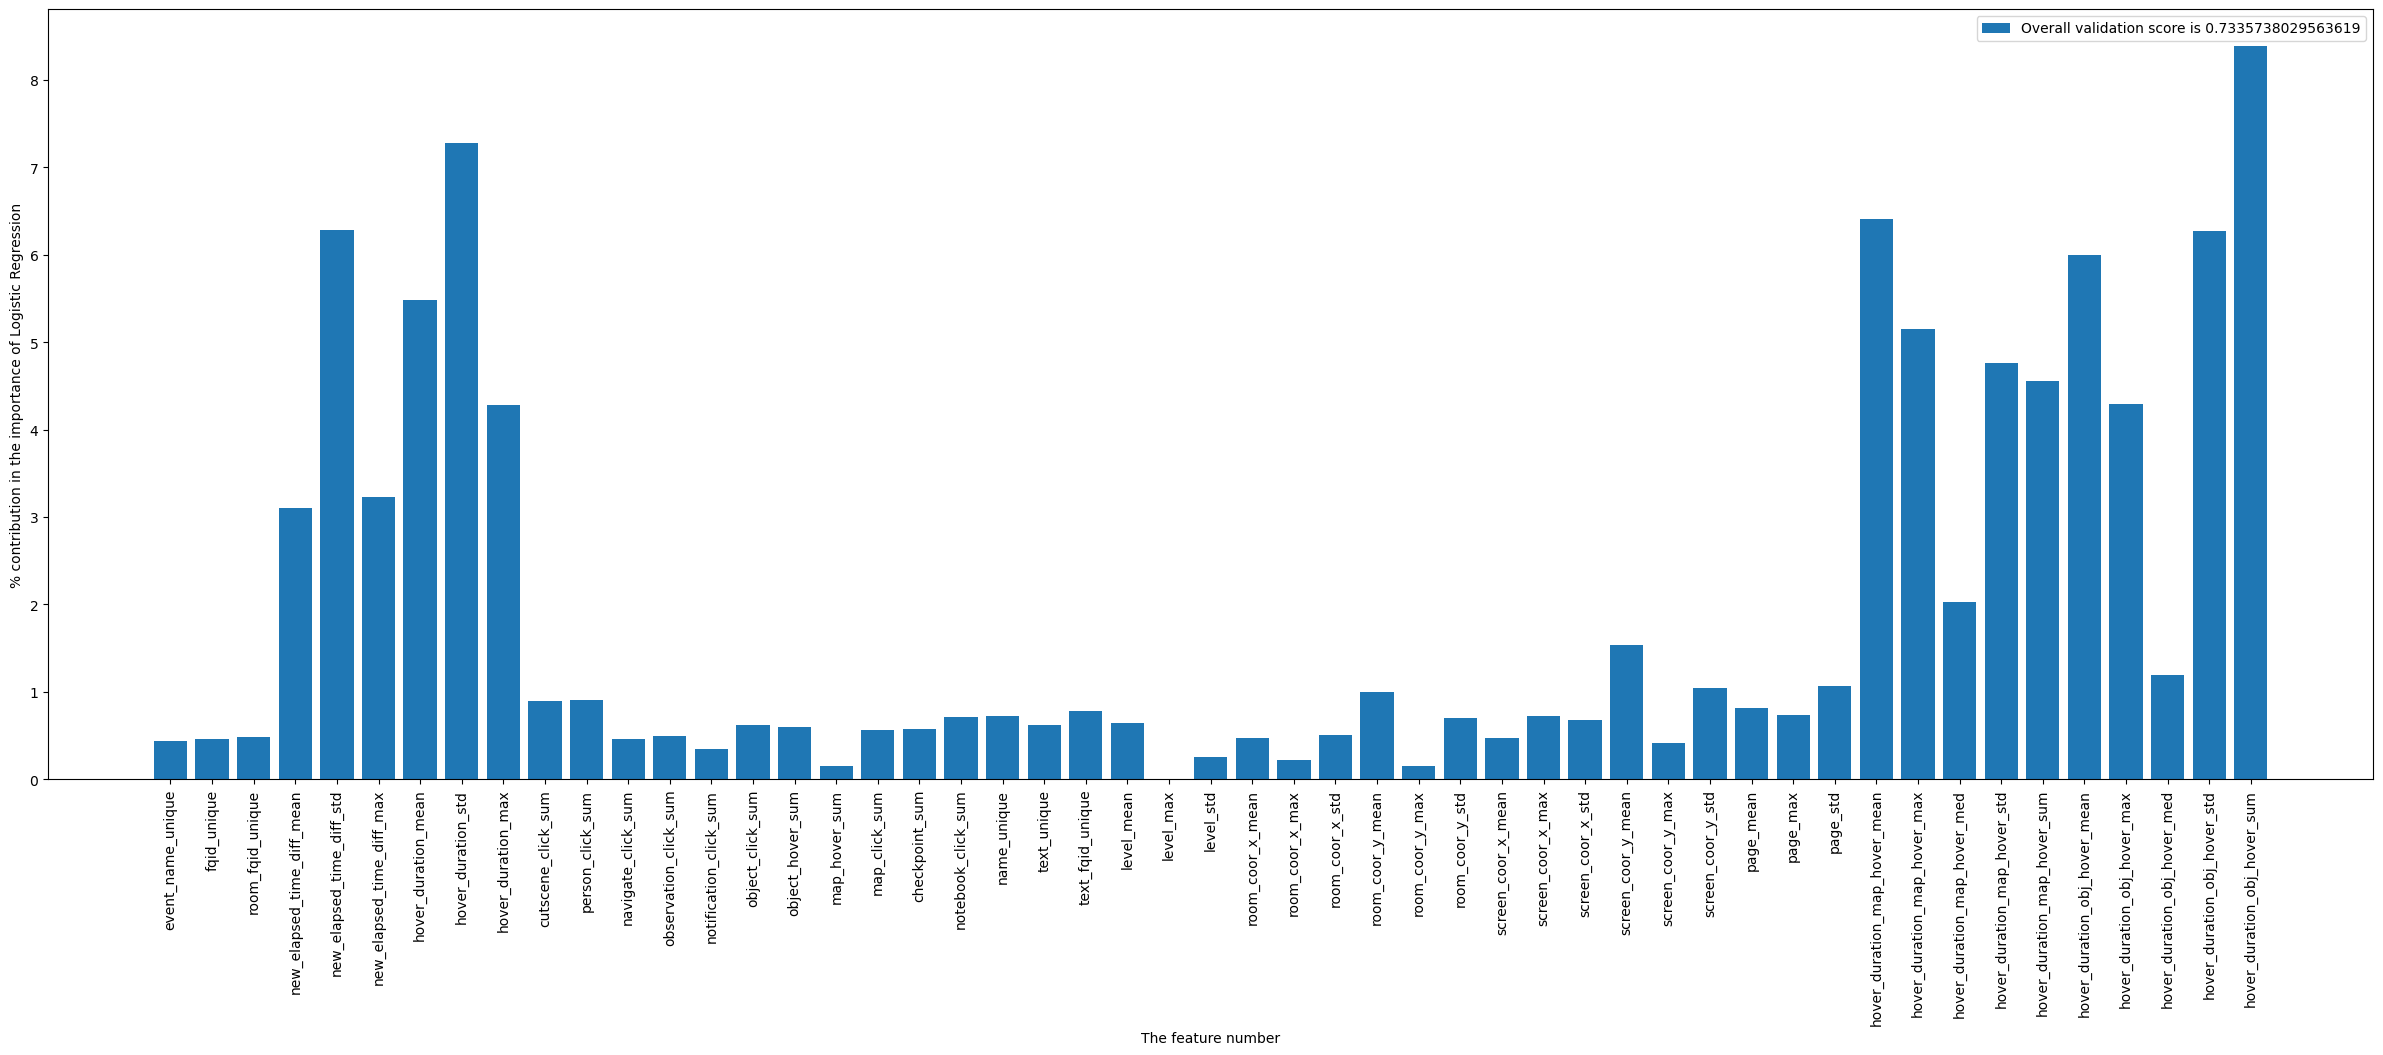

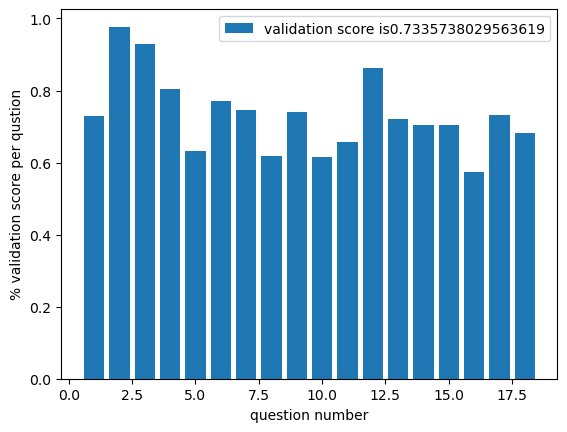

In [15]:
# logistic regression should be a bit more rich and as robust as the linear classifier
class Question_classifier(Pipeline):
    def __init__(self) -> None:
        #super().__init__()
        self.Pipe = Pipeline([('scaler',StandardScaler()),
                              ('model',LogisticRegression(C=10,max_iter=1000))])
        # self.Pipe = Pipeline([('model',LogisticRegression(C=1))])
    def fit(self,X,Y):
        self.Pipe.fit(X,Y)
    def predict(self,X):
        return self.Pipe.predict(X)
    def score(self,X,Y):
        return self.Pipe.score(X,Y)
    
X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
          X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
          X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
Y_train = [y1_train,y2_train,y3_train,y4_train,
           y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
           y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
         X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
         X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

Y_val = [y1_val,y2_val,y3_val,y4_val,
          y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
          y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

Q=[]
train_score =[]
val_score =[]
for i in range(18):
    Q.append(Question_classifier())
    Q[i].fit(X_train[i],Y_train[i])
    train_score.append(Q[i].score(X_train[i],Y_train[i]))
    val_score.append(Q[i].score(X_val[i],Y_val[i]))

print("training average score using Logistic regression with 0.1 reg", np.array(train_score).mean())
print(train_score)
print("validation average score using Logistic regression with 0.1 reg", np.array(val_score).mean())
print(val_score)
if (True):
    temp=np.array(Q[0].Pipe.steps[1][1].coef_)
    imp=np.zeros(temp.shape)
    for i in range(18):
        temp=np.array(Q[i].Pipe.steps[1][1].coef_)
        temp = np.abs(temp/np.max(np.abs(temp)))
        imp = imp+temp
        #print(f"for Q{i}, per feature imprtance is {temp}")
    imp = 100*imp/np.sum(imp)
    print(f" overal feature imprtances as % are {imp}")
    imp=imp[0,:]
    plt.figure(0,figsize=(30,10))
    plt.bar(np.arange(len(imp)),imp,label=f"Overall validation score is {np.array(val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("The feature number")
    plt.ylabel("% contribution in the importance of Logistic Regression")
    plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    plt.figure(1)
    plt.bar(np.arange(1,len(val_score)+1),val_score,label=f"validation score is{np.array(val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("question number")
    plt.ylabel("% validation score per qustion")
    

In [196]:
# if (True):
#     temp=np.array(Q[0].Pipe.steps[1][1].coef_)
#     imp=np.zeros(temp.shape)
#     temp=np.array(Q[15].Pipe.steps[1][1].coef_)
#     temp = np.abs(temp/np.max(np.abs(temp)))
#     imp = imp+temp
#     imp = 100*imp/np.sum(imp)
#     print(f" Q15 overal feature imprtances as % are {imp}")
#     imp=imp[0,:]
#     plt.figure(0)
#     plt.bar(np.arange(len(imp)),imp,label=f"Overall validation score is {np.array(val_score).mean()}")
#     plt.legend(loc='best')
#     plt.xlabel("The feature number")
#     plt.ylabel("% contribution in the importance of Logistic Regression")
#     plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)

d:\Kaggle\A_students_performance\tensorflow_lib\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Kaggle\A_students_performance\tensorflow_lib\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

training average score using Logistic regression with 0.1 reg 0.7337907699200075
[0.7296938829646135, 0.9783542893522202, 0.9335243248978725, 0.8003607618441296, 0.6260809592020797, 0.7827470953366227, 0.7390843015544591, 0.6250729481670115, 0.7429571860576157, 0.6014112154490955, 0.6539338956973845, 0.8617963817709162, 0.7243355085150406, 0.7084725980158099, 0.7084725980158099, 0.5706934054857021, 0.7342034060162342, 0.6870391002175181]
validation average score using Logistic regression with 0.1 reg 0.7350590565103614
[0.7343517929132187, 0.9798429874814343, 0.9335879482283047, 0.7903670698069171, 0.6337789093995332, 0.7825164438786336, 0.7371101209420751, 0.6174411203055379, 0.7487799702949289, 0.6210481646509655, 0.6564820708678124, 0.8635688521111818, 0.728835136855506, 0.7018883938043708, 0.7018883938043708, 0.573520050922979, 0.7375344791003607, 0.6885211118183747]
F1 validation average score using  Logistic regression with 0.1 reg 0.512248054672424
F1 validation effective score 

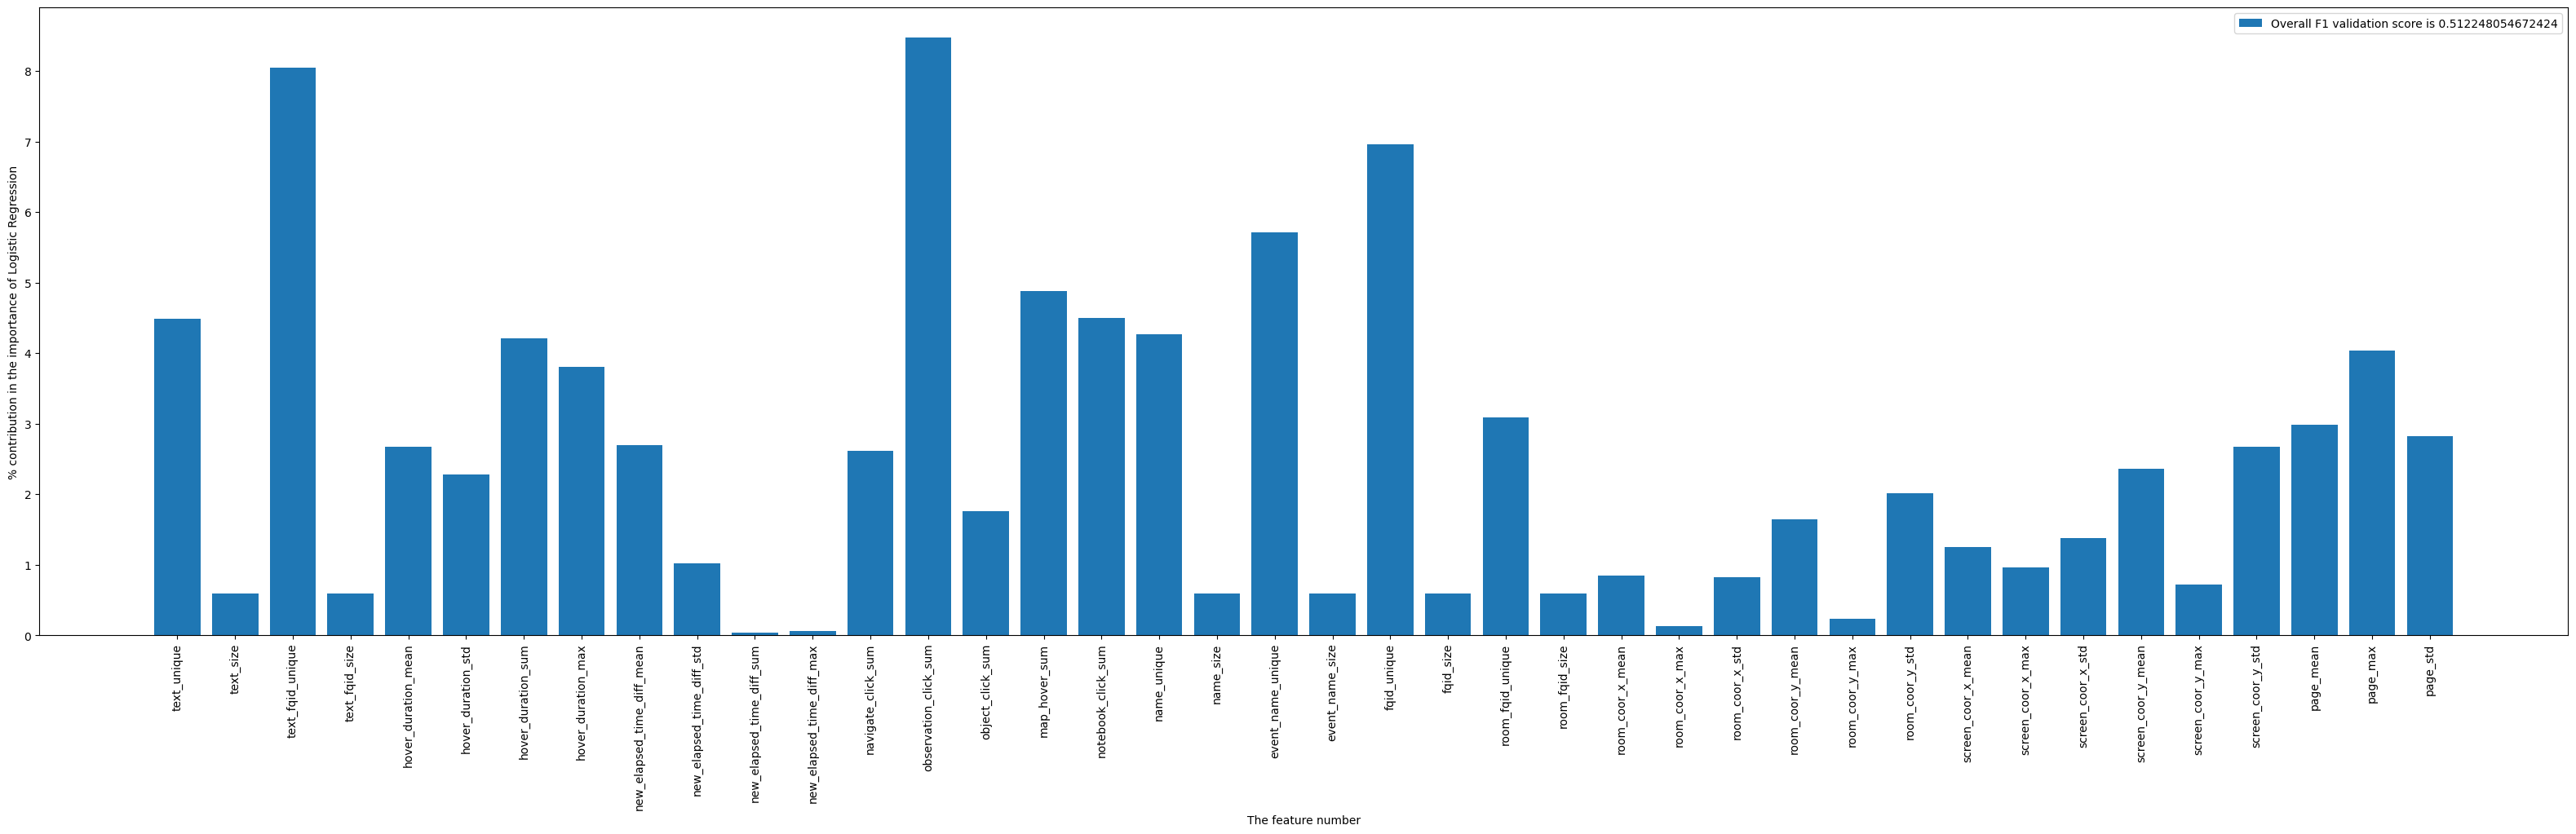

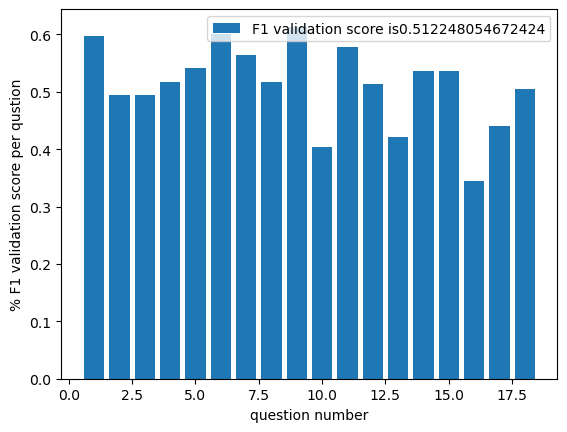

In [10]:
# logistic regression without standard scaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,RobustScaler
class Question_classifier(Pipeline):
    def __init__(self,threshold) -> None:
        #super().__init__()
        # self.Pipe = Pipeline([('scaler',StandardScaler()),
        #                       ('model',LogisticRegression(C=10,max_iter=1000))])
        self.Pipe = Pipeline([('model',LogisticRegression(C=10,max_iter=1000,multi_class='ovr',class_weight={0:1,1:1}))])
        self.threshold=threshold
    def fit(self,X,Y):
        self.Pipe.fit(X,Y)
    def predict_nothreshold(self,X):
        return self.Pipe.predict(X)
    def predict(self,X):
        p=self.Pipe.predict_proba(X)
        return (p[:,1]>self.threshold).astype('int')
    def score(self,X,Y):
        return self.Pipe.score(X,Y)
    
X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
          X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
          X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
Y_train = [y1_train,y2_train,y3_train,y4_train,
           y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
           y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
         X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
         X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

Y_val = [y1_val,y2_val,y3_val,y4_val,
          y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
          y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

Q=[]
train_score =[]
val_score =[]
F1_val_score = []
thresholds = np.ones((18,1))*0.65

#https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664
Y_pred =[]
for i in range(18):
    Q.append(Question_classifier(thresholds[i]))
    Q[i].fit(X_train[i],Y_train[i])
    train_score.append(Q[i].score(X_train[i],Y_train[i]))
    val_score.append(Q[i].score(X_val[i],Y_val[i]))
    Y_pred.append(Q[i].predict(X_val[i]))
    F1_val_score.append(f1_score(Y_val[i],Y_pred[i],average='macro'))

print("training average score using Logistic regression with 0.1 reg", np.array(train_score).mean())
print(train_score)
print("validation average score using Logistic regression with 0.1 reg", np.array(val_score).mean())
print(val_score)
print("F1 validation average score using  Logistic regression with 0.1 reg", np.array(F1_val_score).mean())
print("F1 validation effective score using  Logistic regression with 0.1 reg", np.array(f1_score(np.array(Y_val).reshape(-1),np.array(Y_pred).reshape(-1),average='macro')).mean())
print(F1_val_score)
if (True):
    temp=np.array(Q[0].Pipe.steps[0][1].coef_)
    imp=np.zeros(temp.shape)
    for i in range(18):
        temp=np.array(Q[i].Pipe.steps[0][1].coef_)
        temp = np.abs(temp/np.max(np.abs(temp)))
        imp = imp+temp
        #print(f"for Q{i}, per feature imprtance is {temp}")
    imp = 100*imp/np.sum(imp)
    print(f" overal feature imprtances as % are {imp}")
    imp=imp[0,:]
    plt.figure(0,figsize=(40,10))
    plt.bar(np.arange(len(imp)),imp,label=f"Overall F1 validation score is {np.array(F1_val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("The feature number")
    plt.ylabel("% contribution in the importance of Logistic Regression")
    plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    plt.figure(1)
    plt.bar(np.arange(1,len(F1_val_score)+1),F1_val_score,label=f"F1 validation score is{np.array(F1_val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("question number")
    plt.ylabel("% F1 validation score per qustion")
    #plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    

In [369]:
print("F1 validation effective score using  Logistic regression with 0.1 reg", np.array(f1_score(np.array(Y_val).reshape(-1),np.array(Y_pred).reshape(-1),average='macro')).mean())

F1 validation effective score using  Logistic regression with 0.1 reg 0.6606328169745167


In [151]:
gkf = GroupKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(gkf.split(X=training_data_0_4_w_labels,groups=training_data_0_4_w_labels.index)):
    print(train_index.shape)
    pass

(18849,)
(18849,)
(18850,)
(18850,)
(18850,)


training average score using Decision Tree 0.7338880341426894
[0.7296938829646135, 0.9787787150511964, 0.9341079102339647, 0.8016340389410579, 0.621783648999947, 0.7850814366809911, 0.7417369621730596, 0.6241179903443154, 0.744071303517428, 0.5977505437954268, 0.6581781526871452, 0.8630696588678445, 0.7243885617274126, 0.7101703008117142, 0.7101703008117142, 0.5616743593824606, 0.7353175234760465, 0.6882593241020744]


C:\Users\tarek\AppData\Local\Temp\ipykernel_56740\3427948583.py:53: RuntimeWarning: Mean of empty slice.
  print("validation average score using  Decision Tree", np.array(val_score).mean())
d:\Kaggle\A_students_performance\tensorflow_lib\.conda\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


validation average score using  Decision Tree nan
[]
F1 validation average score using  Decision Tree 0.5086044667014122
F1 validation effective score using  Logistic regression with 0.1 reg 0.6553001388484022
[0.5427485027582429, 0.5052176286560145, 0.4828267310435641, 0.507125403166391, 0.5938391711511577, 0.5889401839387471, 0.5482164947849182, 0.539128840672404, 0.5977708141235039, 0.48902246177958414, 0.5799945681453247, 0.5179649650003105, 0.42143383255585565, 0.4562847922942685, 0.4562847922942685, 0.3960336355328041, 0.4398555933015544, 0.4921919894265027]
 overal feature imprtances as % are [ 1.06485757  7.77356711  1.01490741  7.40622756  3.8682201   2.1701154
  0.53564781  1.25589142  1.53116352  0.16646274  0.267935    0.81161626
  1.65564135  0.70023225 15.39403024  0.20767649  0.74997105  0.65742938
 11.88101382  0.19147423  4.57484162  0.93243714  4.94028626  0.68619325
 11.19884984  0.4455454   1.06607798  1.43387823  2.52628916  0.80863589
  1.14508073  0.75551928  1.1

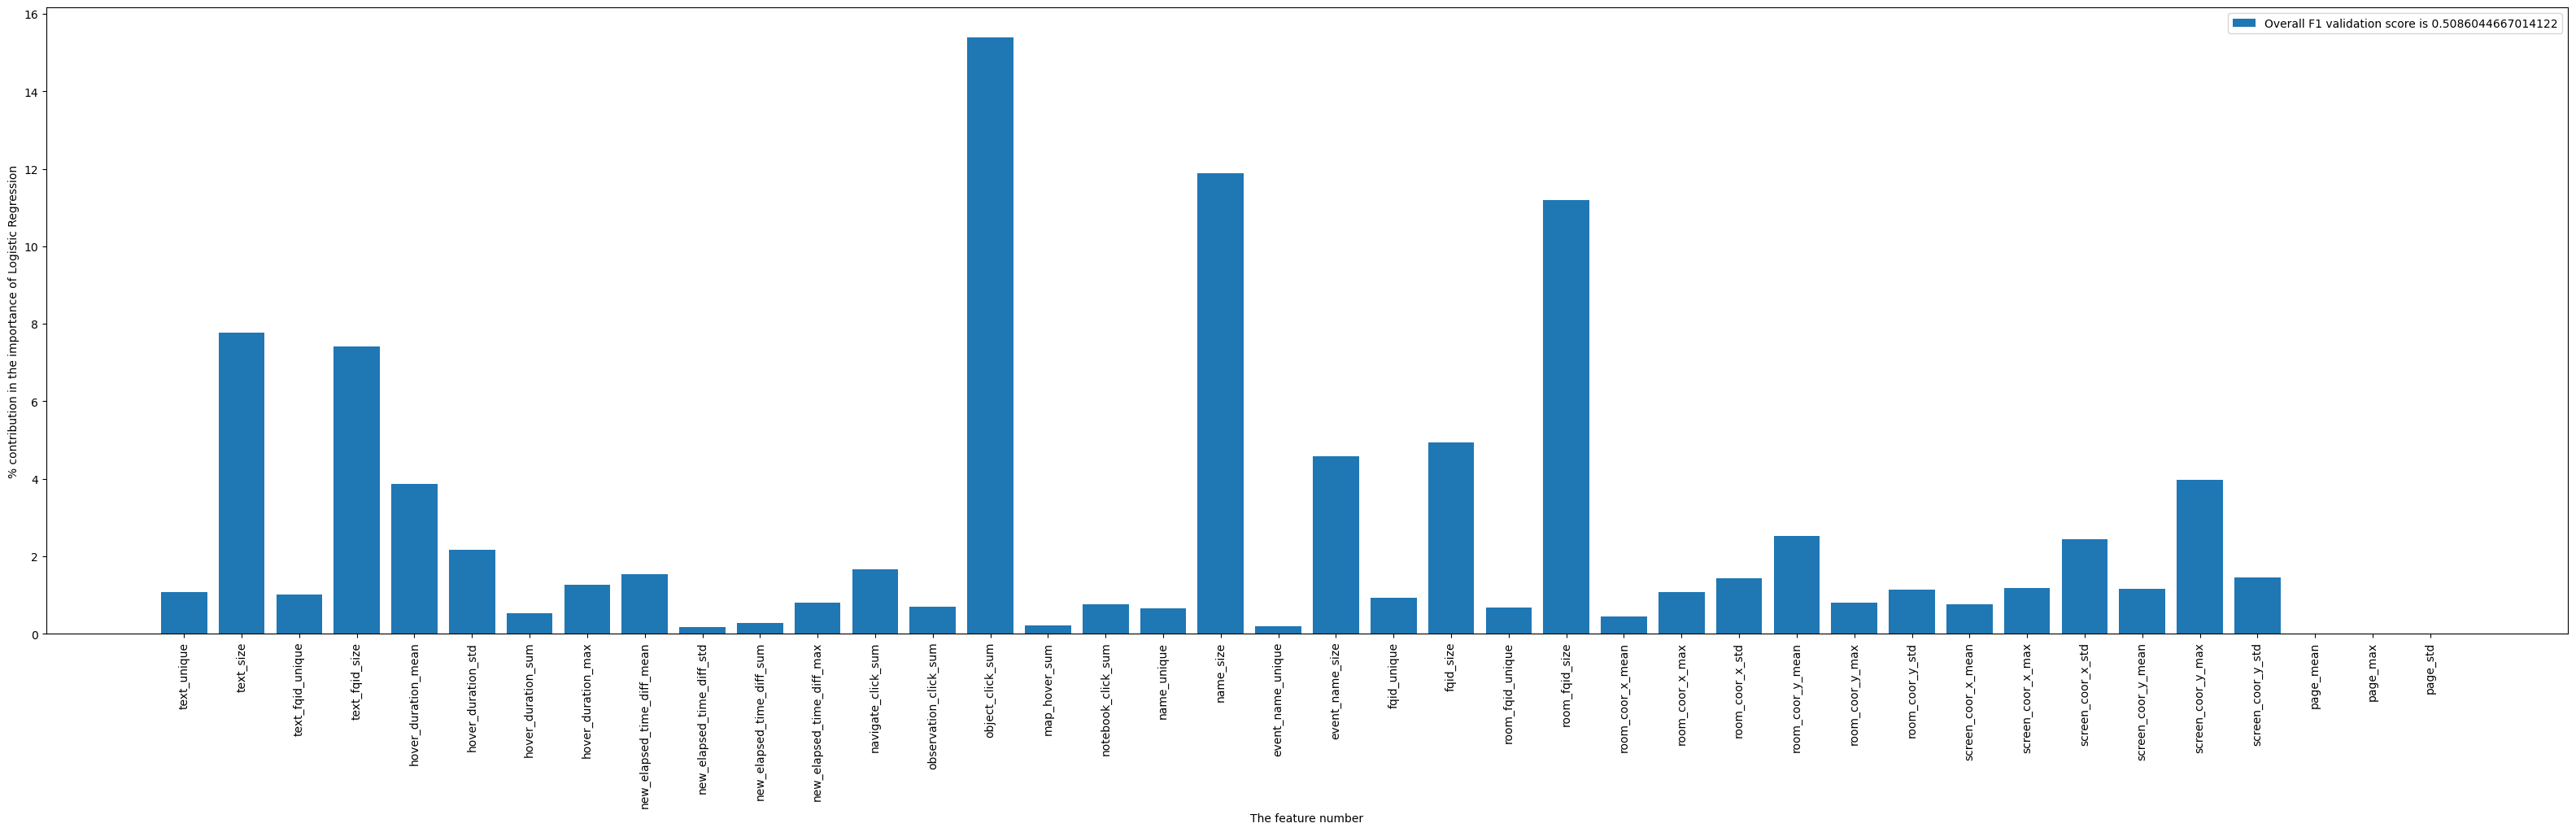

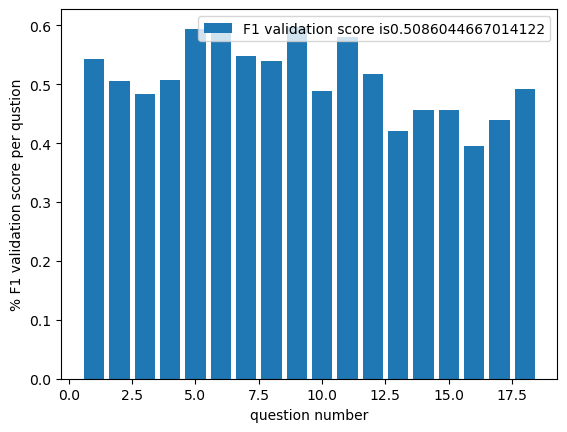

In [11]:

class Question_classifier(Pipeline):
    def __init__(self,threshold,r) -> None:
        #super().__init__()
        self.balancing=r
        self.Pipe = Pipeline([('model',DecisionTreeClassifier(max_depth=4,criterion="entropy",class_weight={0:self.balancing,1:1}))])
        self.threshold=threshold
        # self.Pipe = Pipeline([('model',ExtraTreeClassifier(max_depth=5,criterion="entropy",class_weight={0:1,1:1}))])
        # self.Pipe = Pipeline([('model',RandomForestClassifier(max_depth=5))])
    def fit(self,X,Y):
        self.Pipe.fit(X,Y)
    def predict_nothreshold(self,X):
        return self.Pipe.predict(X)
    def predict(self,X):
        p=self.Pipe.predict_proba(X)
        return (p[:,1]>self.threshold).astype('int')
    def score(self,X,Y):
        return self.Pipe.score(X,Y)
    
X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
          X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
          X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
Y_train = [y1_train,y2_train,y3_train,y4_train,
           y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
           y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
         X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
         X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

Y_val = [y1_val,y2_val,y3_val,y4_val,
          y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
          y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

Q=[]
train_score =[]
val_score =[]
F1_val_score = []
thresholds = np.ones((18,1))*0.62
Y_pred =[]
for i in range(18):
    r=1/(sum(Y_train[i]==0)/len(Y_train[i]))
    if r>4:
        r=5
    r=1
    Q.append(Question_classifier(thresholds[i],r))
    Q[i].fit(X_train[i],Y_train[i])
    train_score.append(Q[i].score(X_train[i],Y_train[i]))
    Y_pred.append(Q[i].predict(X_val[i]))
    F1_val_score.append(f1_score(Y_val[i],Y_pred[i],average='macro'))

print("training average score using Decision Tree", np.array(train_score).mean())
print(train_score)
print("validation average score using  Decision Tree", np.array(val_score).mean())
print(val_score)
print("F1 validation average score using  Decision Tree", np.array(F1_val_score).mean())
print("F1 validation effective score using  Logistic regression with 0.1 reg", np.array(f1_score(np.array(Y_val).reshape(-1),np.array(Y_pred).reshape(-1),average='macro')).mean())
print(F1_val_score)
if (True):
    temp=np.array(Q[0].Pipe.steps[0][1].feature_importances_)
    imp=np.zeros(temp.shape)
    for i in range(18):
        temp=np.array(Q[i].Pipe.steps[0][1].feature_importances_)
        temp = np.abs(temp/np.max(np.abs(temp)))
        imp = imp+temp
        #print(f"for Q{i}, per feature imprtance is {temp}")
    imp = 100*imp/np.sum(imp)
    print(f" overal feature imprtances as % are {imp}")
    # imp=imp[0,:]
    plt.figure(0,figsize=(40,10))
    plt.bar(np.arange(len(imp)),imp,label=f"Overall F1 validation score is {np.array(F1_val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("The feature number")
    plt.ylabel("% contribution in the importance of Logistic Regression")
    plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    plt.figure(1)
    plt.bar(np.arange(1,len(F1_val_score)+1),F1_val_score,label=f"F1 validation score is{np.array(F1_val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("question number")
    plt.ylabel("% F1 validation score per qustion")
    #plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)

training average score using Decision Tree 0.7522886566337147
[0.761950236086795, 0.9786726086264523, 0.9352750809061489, 0.8068863069658868, 0.6649159106583904, 0.8005199214812457, 0.7634887792455833, 0.6421560825507985, 0.7623746617857712, 0.6478327762746035, 0.6755265531327922, 0.8658284259111889, 0.743646877818452, 0.7172794312695634, 0.7172794312695634, 0.6313862804392806, 0.7347869913523264, 0.6913894636320229]
validation average score using  Decision Tree 0.7360963764528372
[0.7417780606832166, 0.9794186293231487, 0.9306174411203055, 0.806068321663484, 0.6386590282198176, 0.7865478463823466, 0.7354126883089327, 0.6159558667515384, 0.7441120305537874, 0.6076808826649692, 0.6543602800763845, 0.864417568427753, 0.7248037343517929, 0.7158922130277955, 0.7158922130277955, 0.5773392743475493, 0.7368979418629323, 0.6738807553575218]
F1 validation average score using  Decision Tree 0.5280514852162279
F1 validation effective score using  Decision Tree 0.663634219310583
[0.602241198879431

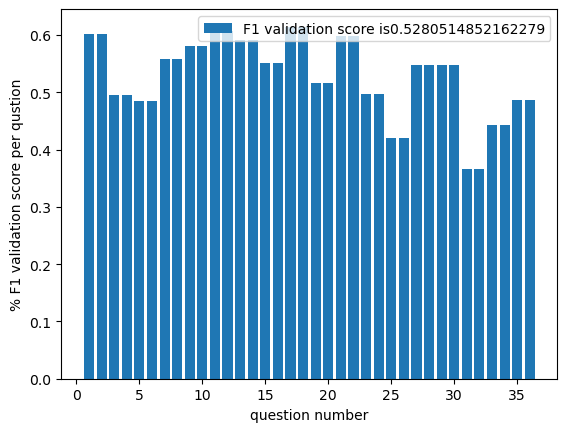

In [381]:
class Question_classifier(XGBClassifier):
    def __init__(self,threshold) -> None:
        #super().__init__()
        self.Pipe = XGBClassifier(objective='binary:logistic',eval_metric='logloss',
                                  learning_rate=0.04,max_depth=4,n_estimators=1000,early_stopping_rounds=50,
                                  tree_method='hist',subsample = 0.7,colsample_bytree=0.5)
        self.threshold=threshold
        # self.Pipe = Pipeline([('model',ExtraTreeClassifier(max_depth=5,criterion="entropy",class_weight={0:1,1:1}))])
        # self.Pipe = Pipeline([('model',RandomForestClassifier(max_depth=5))])
    def fit(self,X,Y,val,verb):
        self.Pipe.fit(X,Y,eval_set=val,verbose=verb)
    def predict_nothreshold(self,X):
        return self.Pipe.predict(X)
    def predict(self,X):
        p=self.Pipe.predict_proba(X)
        return (p[:,1]>self.threshold).astype('int')
    def score(self,X,Y):
        return self.Pipe.score(X,Y)
    
X_train =[X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,X_1_to_4_train,
          X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,X_5_to_12_train,
          X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train,X_13_to_18_train]
Y_train = [y1_train,y2_train,y3_train,y4_train,
           y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train,y12_train,
           y13_train,y14_train,y15_train,y16_train,y17_train,y18_train]

X_val =[X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,X_1_to_4_val,
         X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,X_5_to_12_val,
         X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val,X_13_to_18_val]

Y_val = [y1_val,y2_val,y3_val,y4_val,
          y5_val,y6_val,y7_val,y8_val,y9_val,y10_val,y11_val,y12_val,
          y13_val,y14_val,y15_val,y16_val,y17_val,y18_val]

Q=[]
train_score =[]
val_score =[]
F1_val_score = []
thresholds = np.ones((18,1))*0.63

Y_pred =[]
for i in range(18):
    Q.append(Question_classifier(thresholds[i]))
    Q[i].fit(X_train[i],Y_train[i],[(X_val[i],Y_val[i])],0)
    train_score.append(Q[i].score(X_train[i],Y_train[i]))
    val_score.append(Q[i].score(X_val[i],Y_val[i]))
    F1_val_score.append(f1_score(Y_val[i],Q[i].predict(X_val[i]),average='macro'))
    Y_pred.append(Q[i].predict(X_val[i]))
    F1_val_score.append(f1_score(Y_val[i],Y_pred[i],average='macro'))

print("training average score using Decision Tree", np.array(train_score).mean())
print(train_score)
print("validation average score using  Decision Tree", np.array(val_score).mean())
print(val_score)
print("F1 validation average score using  Decision Tree", np.array(F1_val_score).mean())
print("F1 validation effective score using  Decision Tree", np.array(f1_score(np.array(Y_val).reshape(-1),np.array(Y_pred).reshape(-1),average='macro')).mean())
print(F1_val_score)
if (True):
    # temp=np.array(Q[0].Pipe.steps[0][1].feature_importances_)
    # imp=np.zeros(temp.shape)
    # for i in range(18):
    #     temp=np.array(Q[i].Pipe.steps[0][1].feature_importances_)
    #     temp = np.abs(temp/np.max(np.abs(temp)))
    #     imp = imp+temp
    #     #print(f"for Q{i}, per feature imprtance is {temp}")
    # imp = 100*imp/np.sum(imp)
    # print(f" overal feature imprtances as % are {imp}")
    # # imp=imp[0,:]
    # plt.figure(0,figsize=(40,10))
    # plt.bar(np.arange(len(imp)),imp,label=f"Overall F1 validation score is {np.array(F1_val_score).mean()}")
    # plt.legend(loc='best')
    # plt.xlabel("The feature number")
    # plt.ylabel("% contribution in the importance of Logistic Regression")
    # plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)
    plt.figure(1)
    plt.bar(np.arange(1,len(F1_val_score)+1),F1_val_score,label=f"F1 validation score is{np.array(F1_val_score).mean()}")
    plt.legend(loc='best')
    plt.xlabel("question number")
    plt.ylabel("% F1 validation score per qustion")
    #plt.xticks(np.arange(0, len(imp), step=1),labels=np.array(training_data.columns)[1:],rotation=90)

18

In [168]:
tt= Q[0].Pipe.steps[0][1]
print('depth',tt.get_depth())
print('n_leafs',tt.get_n_leaves())


depth 4
n_leafs 15


In [399]:
# testing_data=pd.read_csv('test.csv',dtype=dtypes)
testing_data_loaded=pd.read_csv('train.csv',dtype=dtypes)
testing_data_loaded=testing_data_loaded.drop(["fullscreen","hq","music"],axis=1)
testing_data_loaded.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [396]:
testing_data_loaded.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'level_group'],
      dtype='object')

In [400]:
# event_name_dummies=pd.get_dummies(testing_data_loaded['event_name'])
# testing_data = pd.concat([testing_data_loaded,event_name_dummies], axis=1)
# testing_data['new_elapsed_time_diff'] = np.append(0,np.abs(np.gradient(testing_data_loaded['elapsed_time'].values))[:-1])
# Events = list(testing_data_loaded['event_name'].unique())
# if multiply_by_time:
#     for c in Events:
#         testing_data[c]=testing_data[c] * testing_data['new_elapsed_time_diff']

testing_data = feature_engineering(testing_data_loaded)
testing_data_0_4= testing_data.loc[testing_data['level_group']=='0-4'].drop('level_group',axis=1) # separating the time series stages
testing_data_5_12 = testing_data.loc[testing_data['level_group']=='5-12'].drop('level_group',axis=1)
testing_data_13_22 = testing_data.loc[testing_data['level_group']=='13-22'].drop('level_group',axis=1)

In [ ]:
session_id = testing_data_0_4.index.astype(str)

X_1_to_4 = testing_data_0_4.values
X_5_to_12 = testing_data_5_12.values
X_13_to_22 = testing_data_13_22.values

NameError: name 'testing_data_0_4' is not defined

In [ ]:
# Q[2].predict(X_1_to_4)

In [ ]:
# The_session_id = session_id.to_frame(index=False)
# q_n ='_q'+str(11)
# The_session_id['session_id']=The_session_id['session_id']+q_n
# The_session_id
# The_session_id['correct']=np.array([1,1,1])
# The_session_id

In [394]:

The_session_id = session_id.to_frame(index=False)
The_predictions = []
for i in range(18):
    question_number = i+1
    q_n ='_q'+str(question_number)
    prediction_df_i = The_session_id.copy()
    prediction_df_i['session_id'] = prediction_df_i['session_id']+q_n
    predicted_answers_qi = []
    if question_number<=4:
        predicted_answers_qi= Q[i].predict(X_1_to_4)
    elif question_number<=12:
        predicted_answers_qi = Q[i].predict(X_5_to_12)
    else:
        predicted_answers_qi = Q[i].predict(X_13_to_22)
    prediction_df_i['correct']=np.array(predicted_answers_qi)
    The_predictions.append(prediction_df_i)
The_predictions=pd.concat(The_predictions)
The_predictions

The_predictions.to_csv('submission.csv',index=False)
    

NameError: name 'session_id' is not defined

In [395]:
yhat= The_predictions['correct'].values
y = training_labels['correct'].values
Acc =np.array(yhat==y).mean()
F1 = f1_score(y,yhat,average='macro')
F1

NameError: name 'The_predictions' is not defined

In [ ]:
predicted_answers_qi= Q[0].predict(X_1_to_4)

In [384]:
type(predicted_answers_qi[0])

numpy.int32

In [ ]:
predicted_answers_qi= Q[13].predict_nothreshold(X_13_to_22)

NameError: name 'X_13_to_22' is not defined

In [ ]:
type(predicted_answers_qi[0])

numpy.int32